In [1]:
%pip install torch torchvision --index-url https://download.pytorch.org/whl/cu128
%pip install matplotlib

Looking in indexes: https://download.pytorch.org/whl/cu128
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torchvision.datasets import ImageFolder
from collections import Counter
import torch

def compute_class_weights_from_imagefolder(data_path, device='cpu', normalize=True):
    """
    Compute inverse frequency weights for ImageFolder dataset.
    Args:
        data_path (str): Path to your dataset root (with subfolders as classes)
        device (str): 'cuda' or 'cpu'
        normalize (bool): Whether to normalize weights to sum to num_classes
    Returns:
        weights (Tensor): Class weights as a FloatTensor
        class_to_idx (dict): Class name to index mapping
    """
    dataset = ImageFolder(root=data_path)
    labels = [label for _, label in dataset.samples]
    class_counts = Counter(labels)
    
    # Ensure order matches class index
    num_classes = len(dataset.classes)
    counts = torch.tensor([class_counts[i] for i in range(num_classes)], dtype=torch.float)

    weights = counts.sum() / counts  # Inverse frequency

    if normalize:
        weights = weights / weights.sum() * num_classes  # Normalize to sum=num_classes

    return weights.to(device), dataset.class_to_idx

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torchvision

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

dataset = datasets.ImageFolder('./colored_images', transform=transform)
weights, class_to_idx = compute_class_weights_from_imagefolder("./colored_images", device=device)

class_names = dataset.classes
print(f"Labels: {class_names}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, num_workers=24, pin_memory=True, shuffle=False)

Labels: ['Mild', 'Moderate', 'No_DR', 'Proliferate_DR', 'Severe']


In [6]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

In [7]:
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.shared_MLP = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )

        self.sigmoid_channel = nn.Sigmoid()

        self.conv_spatial = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size // 2, bias=False)
        self.sigmoid_spatial = nn.Sigmoid()

    def forward(self, x):
        avg = self.shared_MLP(self.avg_pool(x))
        max = self.shared_MLP(self.max_pool(x))
        x = x * self.sigmoid_channel(avg + max)

        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial = self.sigmoid_spatial(self.conv_spatial(torch.cat([avg_out, max_out], dim=1)))
        return x * spatial

In [8]:
class CBAM_DenseNet121_LSTM(nn.Module):
    def __init__(self, lstm_hidden_size=129, num_classes=5):
        super().__init__()

        base = models.densenet121(pretrained=True)
        self.backbone = base.features
        self.feature_extractor = nn.Sequential(
            self.backbone,
            nn.AdaptiveAvgPool2d((7, 7)),
            CBAM(1024)
        )

        self.lstm = nn.LSTM(input_size=49, hidden_size=lstm_hidden_size, num_layers=2, batch_first=True)
        
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), 1024, -1)
        
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        
        return self.fc(out)


In [9]:
model = CBAM_DenseNet121_LSTM(num_classes=len(dataset.classes)).to(device=device)
# criterion = nn.CrossEntropyLoss()
criterion = FocalLoss(gamma=2.0, weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',         # 'min' if you're tracking loss, 'max' if tracking accuracy
    factor=0.5,         # Reduce LR by this factor
    patience=5,         # Wait N epochs before reducing
)

/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/Developer/diabetic-retinopathy/.conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
batch_size = 32
num_epochs = 100
best_val_acc = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_acc = 100 * correct / total
    avg_loss = total_loss / len(train_loader)

    # ----------------------------
    # Validation Loop
    # ----------------------------
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100 * val_correct / val_total
    avg_val_loss = val_loss / len(val_loader)

    # ----------------------------
    # Save best model
    # ----------------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")

    scheduler.step(avg_val_loss)  # or use val_acc with mode='max'
    for param_group in optimizer.param_groups:
        print(f"Current LR: {param_group['lr']}")

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"Train Loss: {avg_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Current LR: 0.001
Epoch [1/100] - Train Loss: 0.3840, Train Acc: 39.33% | Val Loss: 0.3568, Val Acc: 48.43%
Current LR: 0.001
Epoch [2/100] - Train Loss: 0.3628, Train Acc: 44.97% | Val Loss: 0.3255, Val Acc: 52.39%
Current LR: 0.001
Epoch [3/100] - Train Loss: 0.3333, Train Acc: 45.76% | Val Loss: 0.3400, Val Acc: 50.21%
Current LR: 0.001
Epoch [4/100] - Train Loss: 0.3107, Train Acc: 46.68% | Val Loss: 0.2993, Val Acc: 41.31%
Current LR: 0.001
Epoch [5/100] - Train Loss: 0.2837, Train Acc: 48.87% | Val Loss: 0.2964, Val Acc: 48.84%
Current LR: 0.001
Epoch [6/100] - Train Loss: 0.2807, Train Acc: 46.96% | Val Loss: 0.2636, Val Acc: 31.60%
Current LR: 0.001
Epoch [7/100] - Train Loss: 0.2684, Train Acc: 49.38% | Val Loss: 0.3095, Val Acc: 48.84%
Current LR: 0.001
Epoch [8/100] - Train Loss: 0.2508, Train Acc: 51.13% | Val Loss: 0.2685, Val Acc: 54.99%
Current LR: 0.001
Epoch [9/100] - Train Loss: 0.2537, Train Acc: 48.63% | Val Loss: 0.2501, Val Acc: 58.96%
Current LR: 0.001
Epoch [10/

KeyboardInterrupt: 

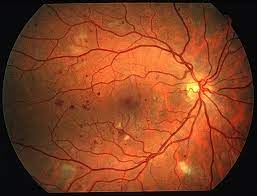


📷 Image: /home/john/Developer/diabetic-retinopathy/images (2).jpeg
✅ Predicted Class: Mild

📊 Confidence per class:
  Mild           : 39.98%
  Moderate       : 30.65%
  No_DR          : 8.26%
  Proliferate_DR : 15.91%
  Severe         : 5.20%


In [15]:
from PIL import Image
import torch
from torchvision import transforms
from tkinter import filedialog
from IPython.display import Image as I, display
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # If not pretrained, otherwise use ImageNet stats
])

def load_image():
    image_path = filedialog.askopenfilename(title="Select an image",
                                            filetypes=[("Image Files", "*.jpg *.png *.jpeg")])
    if not image_path:
        print("No image selected.")
        return None, None
    
    display(I(filename=image_path, width=224, height=224))
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    return img_tensor, image_path

# === Inference with confidence display ===
model.eval()
with torch.no_grad():
    img_tensor, path = load_image()
    if img_tensor is not None:
        output = model(img_tensor)                     # raw logits
        probs = F.softmax(output, dim=1)[0]            # softmax → probabilities
        _, predicted = torch.max(probs, dim=0)

        class_names = dataset.classes
        print(f"\n📷 Image: {path}")
        print(f"✅ Predicted Class: {class_names[predicted.item()]}\n")

        print("📊 Confidence per class:")
        for i, prob in enumerate(probs):
            print(f"  {class_names[i]:<15}: {prob.item()*100:.2f}%")


In [ ]:
%pip install opencv-python

  Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (67.0 MB)
Note: you may need to restart the kernel to use updated packages.


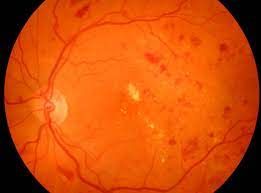

✅ Predicted class: Mild


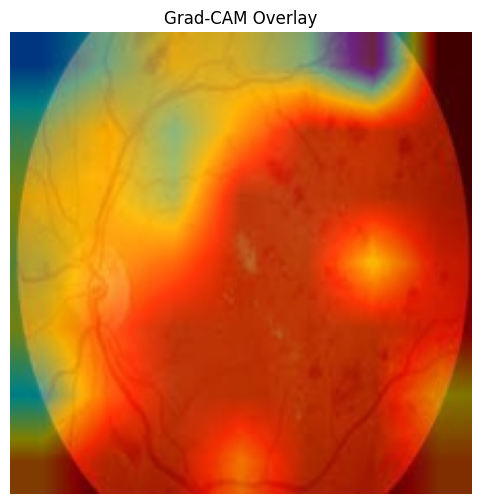

In [24]:
import cv2

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)  # If not pretrained, otherwise use ImageNet stats
])

def load_image():
    image_path = filedialog.askopenfilename(
        title="Select an image",
        filetypes=[("Image Files", "*.jpg *.png *.jpeg")]
    )
    if not image_path:
        print("No image selected.")
        return None, None
    
    display(I(filename=image_path, width=224, height=224))
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    return img_tensor, image_path

def generate_gradcam(model, img_tensor, class_names):
    model.train()  # required for LSTM's backward in cuDNN

    # Hook containers
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    # Hook to last conv layer (example: norm5 in DenseNet121 backbone)
    target_layer = model.backbone.norm5
    handle_f = target_layer.register_forward_hook(forward_hook)
    handle_b = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()
    class_label = class_names[pred_class]

    # Backward pass
    model.zero_grad()
    output[0, pred_class].backward()

    # Unhook to clean up
    handle_f.remove()
    handle_b.remove()

    # Grad-CAM calculation
    grads = gradients[0]              # [B, C, H, W]
    acts = activations[0]            # [B, C, H, W]
    pooled_grads = torch.mean(grads, dim=[0, 2, 3])  # [C]

    for i in range(acts.shape[1]):
        acts[:, i, :, :] *= pooled_grads[i]

    heatmap = torch.mean(acts, dim=1).squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()

    model.eval()  # switch back to eval mode
    return heatmap, class_label


def overlay_gradcam(heatmap, image_path, alpha=0.5):
    img = Image.open(image_path).convert("RGB").resize((224, 224))
    img = np.array(img)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    superimposed_img = cv2.addWeighted(heatmap_color, alpha, img, 1 - alpha, 0)

    plt.figure(figsize=(6, 6))
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CBAM_DenseNet121_LSTM(num_classes=len(dataset.classes)).to(device)
model.load_state_dict(torch.load("best_model.pt", map_location=device))  # optional
model.eval()

class_names = dataset.classes

# Load and classify
img_tensor, path = load_image()
if img_tensor is not None:
    heatmap, predicted_label = generate_gradcam(model, img_tensor, class_names)
    print(f"✅ Predicted class: {predicted_label}")
    overlay_gradcam(heatmap, path)
